#  <center> Speech Emotion Recognition <center>

### build a speech emotion detection classifier.

#### Speech Emotion Recognition.

* Speech Emotion Recognition (SER) is the process of identifying the emotional state of a speaker from the speech signal. It is a subfield of affective computing, which focuses on the design of systems that can recognize, interpret, and respond to human emotions. SER can be performed using a variety of techniques, including signal processing, machine learning, and natural language processing. The goal of SER is to improve the communication between humans and machines by allowing the machine to understand and respond to human emotions.

#### Why we need it?

1. Human-computer interaction: SER can be used to improve human-computer interaction by allowing computers to understand and respond to human emotions.

2. User-centered design: SER can be used to design systems that are better suited to the emotional needs of users.

3. Mental health: SER can be used to monitor the emotional state of individuals with mental health conditions, such as depression or anxiety, and provide appropriate interventions.

4. Call center: SER can be used in call centers to monitor the emotional state of customers and improve customer service.

5. Emotion detection in speech-based intelligent agents or chatbots: SER can be used to improve the user experience and the effectiveness of speech-based agents or chatbots by allowing them to detect and respond to the user's emotions.

6. Speech therapy and rehabilitation: SER can be used to monitor the emotional state of individuals undergoing speech therapy or rehabilitation, and to assess the effectiveness of treatment.

7. Social robotics: SER can be used to improve the interactions between humans and robots by allowing robots to understand and respond to human emotions.

#### Datasets used in this project

* Ryerson Audio-Visual Database of Emotional Speech (Ravdess)

# Importing Libraries

In [124]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [125]:
# Paths for data.
Ravdess = "audio_speech_emotion/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [126]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_dict = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        emotion = int(part[2])
        if int(part[6]) % 2 == 0:
            file_emotion.append("female-" + emotion_dict[emotion])
        else:
            file_emotion.append("male-" + emotion_dict[emotion])
            
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# gender_df = pd.DataFrame(file_gender, columns=['Gender'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
# Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  male-neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
1  male-neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
2  male-neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
3  male-neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
4     male-calm  audio_speech_actors_01-24/Actor_01/03-01-02-01...

In [127]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  male-neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
1  male-neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
2  male-neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
3  male-neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
4     male-calm  audio_speech_actors_01-24/Actor_01/03-01-02-01...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

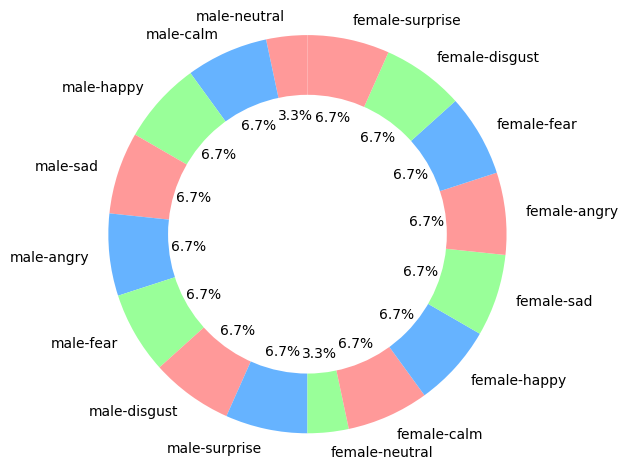

In [128]:
# Count the number of occurrences of each label
label_counts = {}
for label in data_path["Emotions"]:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Create a pie chart of the label counts
labels = list(label_counts.keys())
sizes = [label_counts[label] for label in labels]
colors = ['#ff9999','#66b3ff','#99ff99']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [129]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

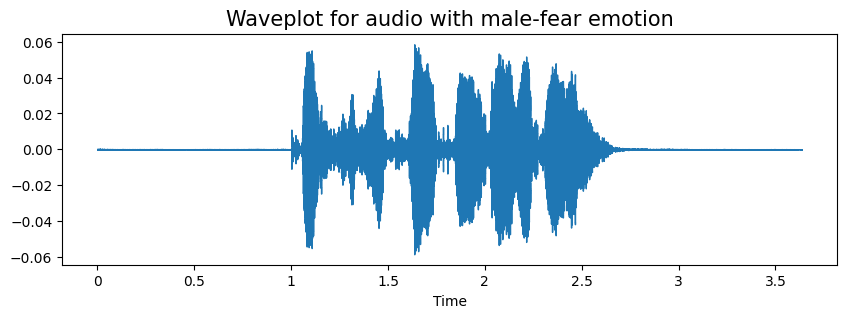

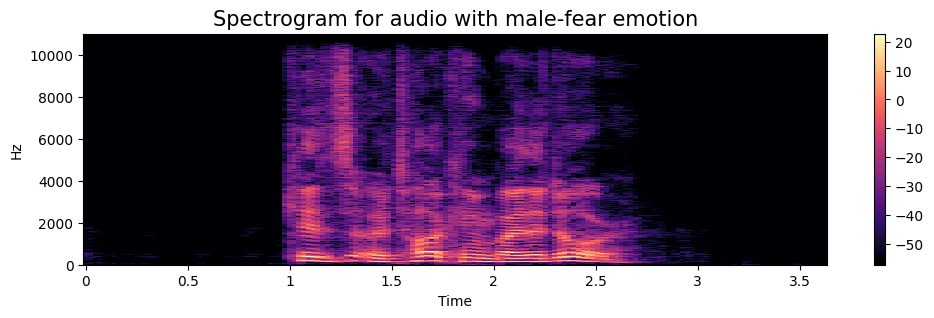

In [130]:
emotion='male-fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

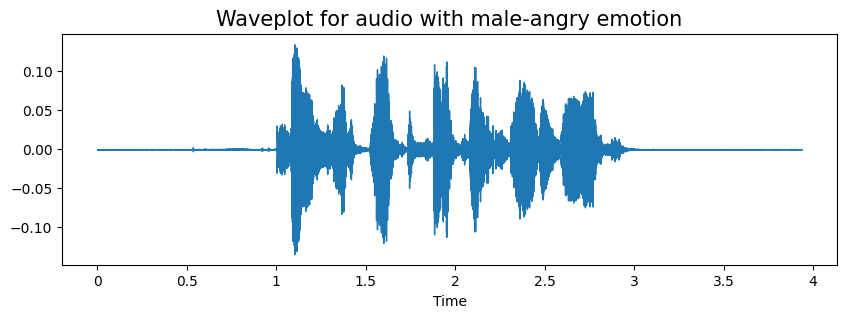

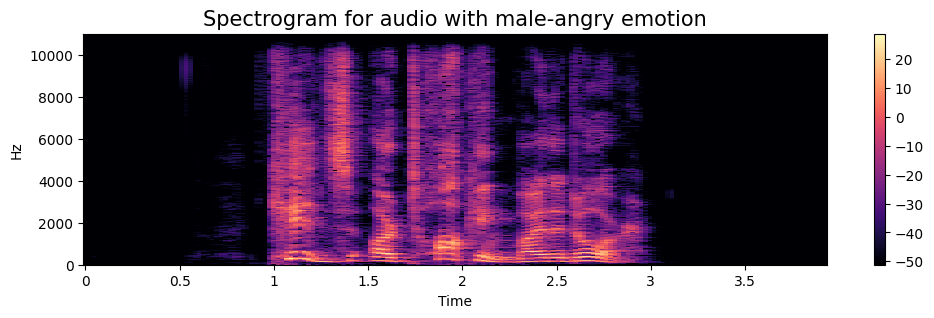

In [131]:
emotion='male-angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

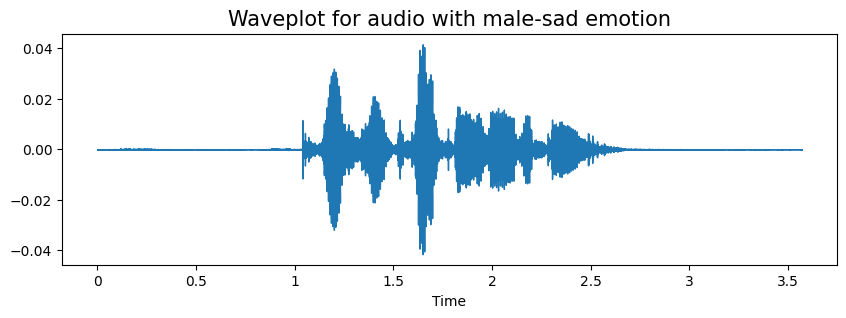

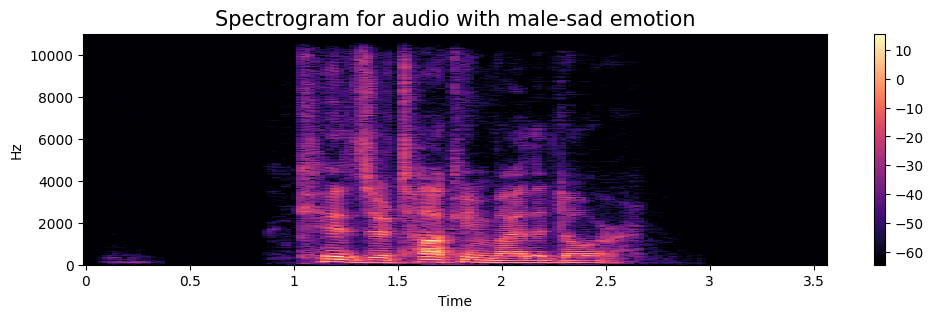

In [132]:
emotion='male-sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

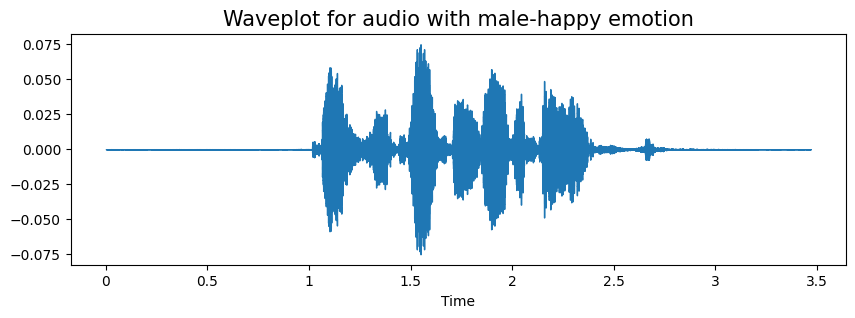

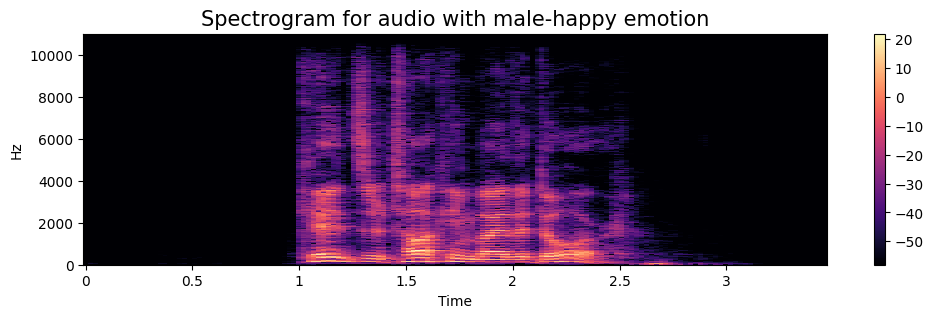

In [133]:
emotion='male-happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation involves creating new synthetic data samples by applying small variations to the initial training set.
- In the case of audio, this can be done by adding noise, shifting time, changing pitch and speed.
- The goal is to make the model insensitive to these variations and improve its ability to generalize.
- For this to be effective, the synthetic samples must retain the same label as the original training sample.
- For images, data augmentation can be done by moving the image, enlarging, and rotating it.

In [134]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

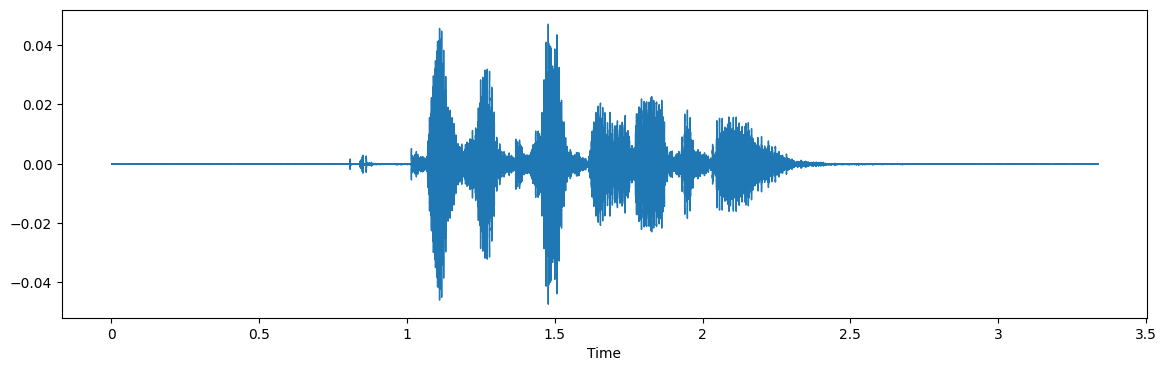

In [135]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

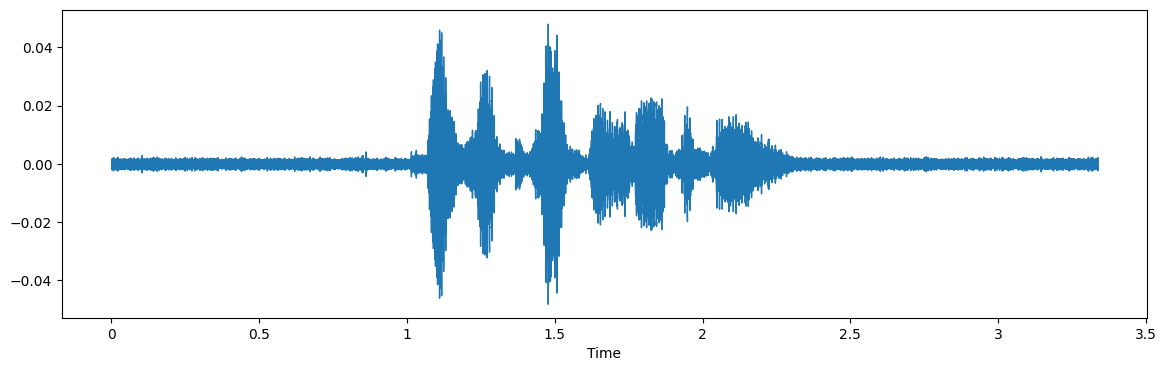

In [136]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Noise injection is an effective augmentation method that ensures the training model is not overfitting.

#### 3. Stretching

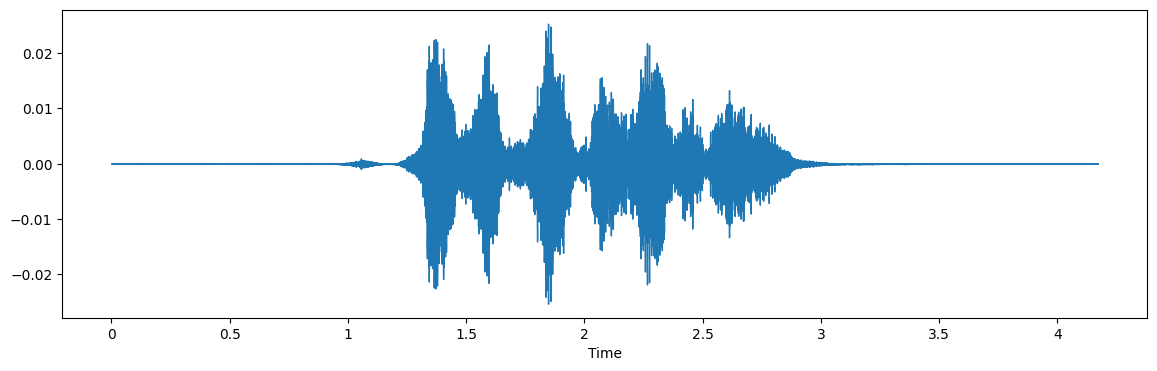

In [137]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

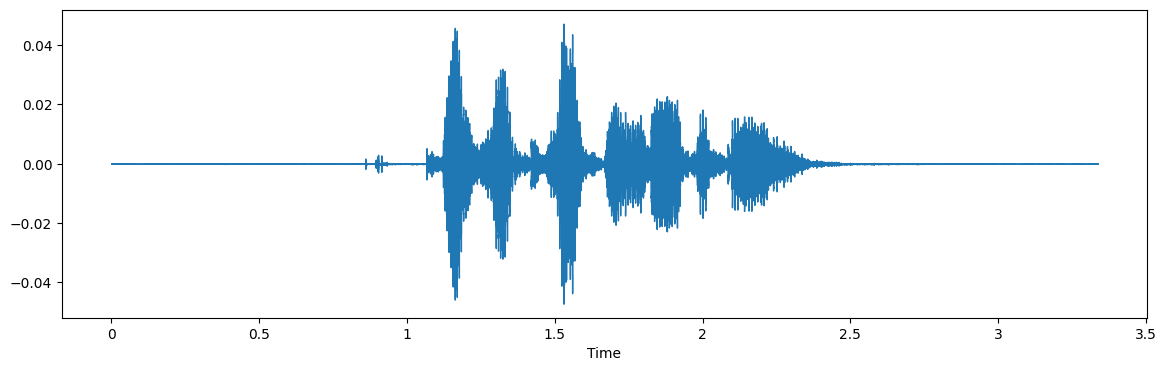

In [138]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

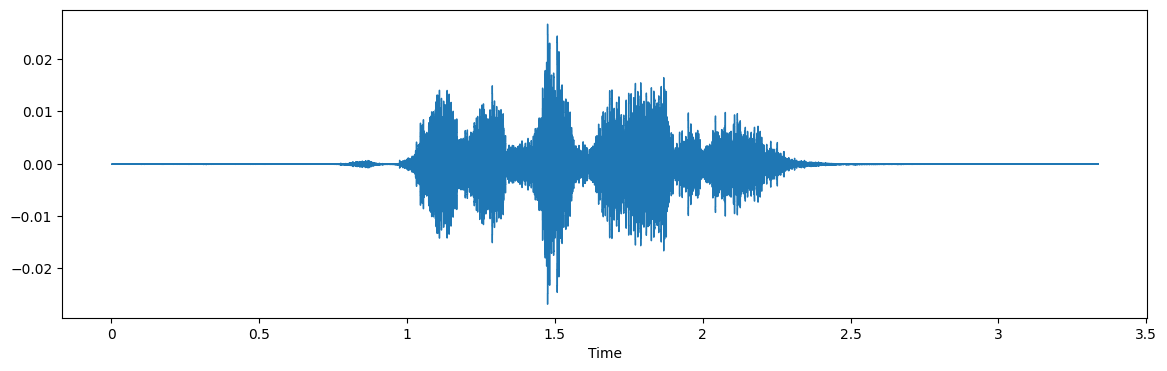

In [139]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- The process of extracting features is crucial in identifying connections between various elements. As audio data is not directly understandable by models, feature extraction is utilized to convert it into a format that can be comprehended.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](image.jpeg)


The sample rate and sample data can be used to perform various transformations to extract useful features. These transformations include:

1. Zero Crossing Rate: which measures the number of times the signal changes during a specific frame.
2. Energy: which calculates the sum of the squares of the signal values normalized by the frame length.
3. Entropy of Energy: which measures sudden changes in the sub-frames' normalized energies.
4. Spectral Centroid: which is the center of mass of the spectrum.
5. Spectral Spread: which is the second central moment of the spectrum.
6. Spectral Entropy: which is the entropy of normalized spectral energies for a set of sub-frames.
7. Spectral Flux: which calculates the squared difference between the normalized magnitudes of the spectra of two consecutive frames.
8. Spectral Rolloff: which is the frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9. MFCCs: which are Mel Frequency Cepstral Coefficients that form a cepstral representation where frequency bands are distributed based on the mel-scale.
10. Chroma Vector: which is a 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music.
11. Chroma Deviation: which is the standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [140]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [141]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [142]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [143]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.283226  0.739174  0.760110  0.738748  0.712194  0.687986  0.667279   
1  0.316045  0.783473  0.832613  0.811884  0.814083  0.810999  0.724386   
2  0.181467  0.629995  0.730929  0.743651  0.680889  0.670727  0.673700   
3  0.254530  0.676571  0.724970  0.725722  0.668644  0.645344  0.671470   
4  0.289044  0.768644  0.799246  0.771162  0.757702  0.779272  0.696949   

          7         8         9  ...           153           154  \
0  0.694000  0.742275  0.762594  ...  4.312694e-06  3.293364e-06   
1  0.681606  0.729435  0.763516  ...  5.494950e-05  5.419468e-05   
2  0.669033  0.709932  0.745144  ...  8.582505e-07  9.570447e-07   
3  0.631493  0.681748  0.709889  ...  6.987414e-06  7.038922e-06   
4  0.649342  0.702867  0.735816  ...  2.327060e-05  2.254835e-05   

            155           156           157           158           159  \
0  2.149554e-06  2.260914e-06  4.562520e-06  4.985616e-06  1.324619e-06   
1  5.243158e-05  5.266814e-05  5.797011e-05  5.531668e-05  5.035864e-05   
2  7.741540e-07  5.212421e-07  3.252106e-07  4.883136e-07  2.353670e-07   
3  6.659573e-06  6.937638e-06  1.117492e-05  5.767251e-06  2.024577e-06   
4  2.152830e-05  2.207316e-05  2.584570e-05  2.113114e-05  1.769324e-05   

            160           161        labels  
0  1.469305e-07  3.053402e-09  male-neutral  
1  5.228969e-05  5.330916e-05  male-neutral  
2  2.240905e-08  9.753157e-11  male-neutral  
3  1.944936e-07  2.701240e-09  male-neutral  
4  1.526264e-05  1.566756e-05  male-neutral  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [144]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [145]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [146]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 16), (1080, 162), (1080, 16))

In [147]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 16), (1080, 162), (1080, 16))

In [148]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 16), (1080, 162, 1), (1080, 16))

## Modelling

In [150]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=16, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 41, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 21, 128)         

In [151]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 17s 309ms/step - loss: 2.6365 - accuracy: 0.1352 - val_loss: 2.4224 - val_accuracy: 0.1907 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 16s 314ms/step - loss: 2.4554 - accuracy: 0.1830 - val_loss: 2.3187 - val_accuracy: 0.2269 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 15s 294ms/step - loss: 2.3536 - accuracy: 0.2000 - val_loss: 2.1548 - val_accuracy: 0.2611 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 15s 294ms/step - loss: 2.2149 - accuracy: 0.2377 - val_loss: 2.0617 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 16s 311ms/step - loss: 2.1069 - accuracy: 0.2722 - val_loss: 1.9293 - val_accuracy: 0.3454 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 16s 315ms/step - loss: 2.0342 - accuracy: 0.2861 - val_loss: 1.8684 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 15s 302ms/st

34/34 [==============================] - 1s 30ms/step - loss: 1.2435 - accuracy: 0.6407
Accuracy of our model on test data :  64.07407522201538 %


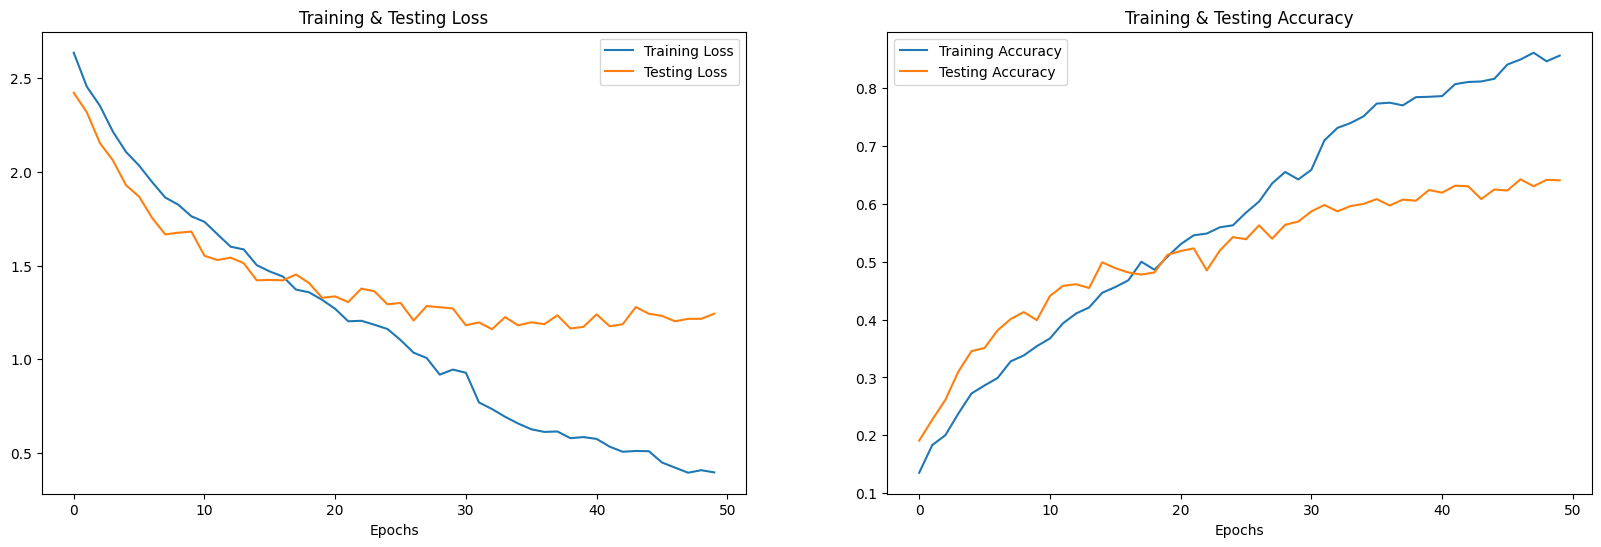

In [152]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [153]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 30ms/step


In [154]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels    Actual Labels
0      female-fear      female-fear
1  female-surprise       male-angry
2      female-fear      female-fear
3   female-neutral      female-calm
4     female-angry     female-angry
5  female-surprise  female-surprise
6        male-calm        male-fear
7        male-fear       male-happy
8      female-fear      female-fear
9        male-calm         male-sad

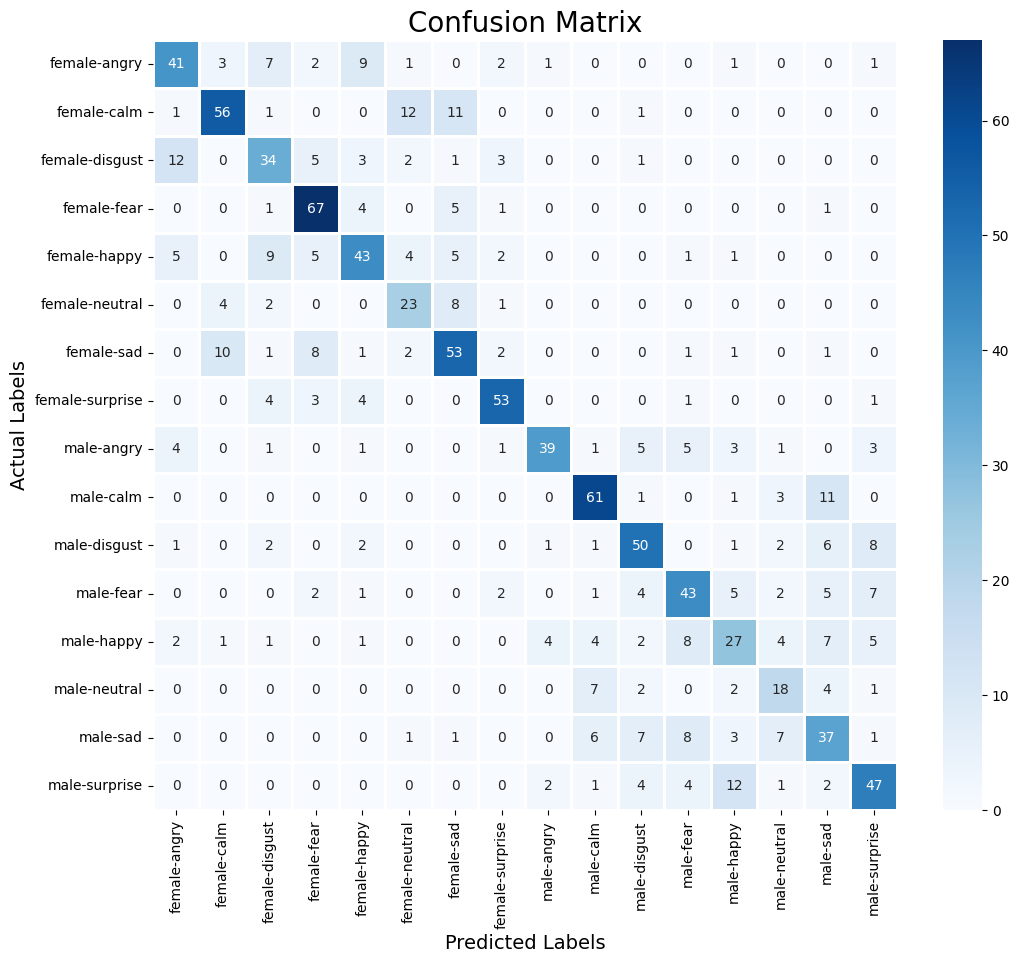

In [155]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [156]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female-angry       0.62      0.60      0.61        68
    female-calm       0.76      0.68      0.72        82
 female-disgust       0.54      0.56      0.55        61
    female-fear       0.73      0.85      0.78        79
   female-happy       0.62      0.57      0.60        75
 female-neutral       0.51      0.61      0.55        38
     female-sad       0.63      0.66      0.65        80
female-surprise       0.79      0.80      0.80        66
     male-angry       0.83      0.61      0.70        64
      male-calm       0.74      0.79      0.77        77
   male-disgust       0.65      0.68      0.66        74
      male-fear       0.61      0.60      0.60        72
     male-happy       0.47      0.41      0.44        66
   male-neutral       0.47      0.53      0.50        34
       male-sad       0.50      0.52      0.51        71
  male-surprise       0.64      0.64      0.64        73

       accuracy              

- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 64% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.